In [53]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
import statistics

In [5]:
# load data as dataframe
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"
count = 0
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    # import data
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [193]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()


df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 5000) & (df1['usd_pledged'] > 100)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 5000) & (df1['usd_pledged'] > 100)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 5000)& (df1['usd_pledged'] > 100)]

df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')

# first sort by category id, then sort by date
df1.sort_values(['category_id', 'deadline'], ascending = [True, True], inplace = True)
df1_success.sort_values(['category_id', 'deadline'], ascending = [True, True], inplace = True)
df1_fail.sort_values(['category_id', 'deadline'], ascending = [True, True], inplace = True)


In [194]:
# write to csv file
df1.to_csv(path2 + "/All.csv", index = False) # 7722
df1_success.to_csv(path2 + "/All_Success.csv", index = False) # 5348
df1_fail.to_csv(path2 + "/All_Fail.csv", index = False)# 2374

# 7722 unique projects that were not cancelled in US with at least $25,000 goal 
# and $2500 pledged from 10/4/2009 - 12/12/2018
# 5348 unique successes
# 2374 unique failures
print(len(df1))
print(len(df1_success))
print(len(df1_fail))

46464
30586
15878


In [195]:
### CALCULATION - PROBABILITY OF SUCCESS

# probability of success per category
category_multi_projects = []
category_success_rate = {}
category_freq = df1['category_name'].value_counts().to_dict()
category_success_freq = df1_success['category_name'].value_counts().to_dict()
category_fail_freq = df1_fail['category_name'].value_counts().to_dict()
# creating list of categories with more than one project
for i in category_freq:
    if category_freq[i] > 1:
        category_multi_projects.append(i)
for j in category_freq:
    if j in category_success_freq.keys():
        category_success_rate[j] = category_success_freq[j] / category_freq[j]
    else: # no successes in these categories
        category_success_rate[j] = 0
    
# probability of success for aggregate categories
success_rate = len(df1_success) / len(df1)
print("Probability of success:")
print(success_rate)

Probability of success:
0.6582730716253443


In [196]:
##### CATEGORIES RESEARCH

In [221]:
### COMPETITION VS. NON-COMPETITION

df2 = df1.copy() # >1 project per category
df2_1 = df1.copy() # 1 project per category

category_single_projects = []
for i in category_freq:
    if category_freq[i] == 1:
        category_single_projects.append(i)
df2 = df2.loc[df2['category_name'].isin(category_multi_projects)]
df2_1 = df2_1.loc[df2_1['category_name'].isin(category_single_projects)]

df3 = pd.DataFrame()
df3_1 = pd.DataFrame()
count = 0
for j in category_multi_projects:
    temp = df2.loc[df2['category_name'] == j]
    temp['overlap'] = (temp['deadline'].shift() - temp['created_at']) > timedelta(0)
    temp1 = temp.loc[temp['overlap'] == True]
    temp2 = temp.loc[temp['overlap'] == False]
    temp1.drop(['overlap'], inplace = True, axis = 1)
    temp2.drop(['overlap'], inplace = True, axis = 1)
    if len(temp1) > 0:
        df3 = df3.append(temp1) # overlapping projects within category
    if len(temp2) > 0:
        df3_1 = df3_1.append(temp2) # non-overlapping projects within category
                 
df3_1 = df3_1.append(df2_1) # single + non-overlapping projects
            
df3_success = df3.loc[df3['state'] == 'successful'] # successful subset for competing projects
df3_fail = df3.loc[df3['state'] == 'failed'] # failed subset for competing projects
df3_1_success = df3_1.loc[df3_1['state'] == 'successful'] # successful subset for non-competing projects
df3_1_fail = df3_1.loc[df3_1['state'] == 'failed'] # failed subset for non-competing projects

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [222]:
# write to csv file
# projects in the same category with overlapping time series
df3.to_csv(path2 + "/All_Competition.csv", index = False) # 6615
df3_success.to_csv(path2 + "/Success_Competition.csv", index = False) # 4578
df3_fail.to_csv(path2 + "/Fail_Competition.csv", index = False) # 2037
df3_1.to_csv(path2 + "/All_Non_Competition.csv", index = False) # 1107
df3_1_success.to_csv(path2 + "/Success_Non_Competition.csv", index = False) # 770
df3_1_fail.to_csv(path2 + "/Fail_Non_Competition.csv", index = False) # 337

# 6615 projects in the same category with overlapping time series
# 4578 of these projects were successful
# 2037 of these projects failed
print(len(df3))
print(len(df3_success))
print(len(df3_fail))

# 1107 projects had no competition
# 770 of these projects were successful
# 337 of these projects failed
print(len(df3_1))
print(len(df3_1_success))
print(len(df3_1_fail))

45168
29782
15386
1296
804
492


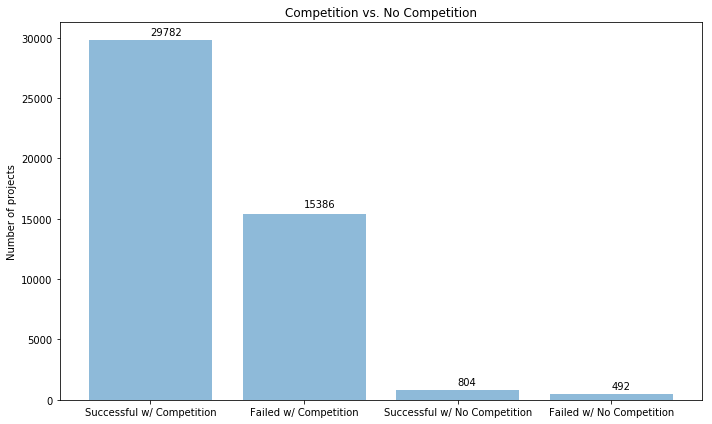

<Figure size 432x288 with 0 Axes>

In [208]:
objects = ('Successful w/ Competition', 'Failed w/ Competition', 
           'Successful w/ No Competition', 'Failed w/ No Competition')
y_pos = np.arange(len(objects))
performance = [len(df3_success), len(df3_fail), len(df3_1_success), len(df3_1_fail)]

fig = plt.figure(figsize=(10, 6))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)

# Create labels
 
# Text on the top of each barplot
plt.text(x = 0 , y = 30200, s = performance[0], size = 10)
plt.text(x = 1 , y = 16000, s = performance[1], size = 10)
plt.text(x = 2 , y = 1250, s = performance[2], size = 10)
plt.text(x = 3 , y = 900, s = performance[3], size = 10)


plt.ylabel('Number of projects')
plt.title('Competition vs. No Competition')

plt.tight_layout()

plt.show()

path3 = "../Desktop/cleaned_kickstarter_plots/"
plt.savefig(path3 + 'Competition_vs_No_Competition.png')

In [200]:
competition_category_success_rate = {}
competition_category_freq = df3['category_name'].value_counts().to_dict()
competition_category_success_freq = df3_success['category_name'].value_counts().to_dict()
competition_category_fail_freq = df3_fail['category_name'].value_counts().to_dict()

non_competition_category_success_rate = {}
non_competition_category_freq = df3_1['category_name'].value_counts().to_dict()
non_competition_category_success_freq = df3_1_success['category_name'].value_counts().to_dict()
non_competition_category_fail_freq = df3_1_fail['category_name'].value_counts().to_dict()

In [201]:
### CALCULATION - NUMBER OF PROJECTS PER CATEGORY

# all
category_num = dict()
for k, v in category_freq.items():
    category_num[k] = [v]

# all success
for k, v in category_freq.items():
    if k in category_success_freq.keys():
        category_num[k].append(category_success_freq[k])
    else: # no successes in these categories
        category_num[k].append(0)
# all fail        
for k, v in category_freq.items():
    if k in category_fail_freq.keys():
        category_num[k].append(category_fail_freq[k])
    else:
        category_num[k].append(0)

#-------------------

# competition
for k, v in category_freq.items():
    if k in competition_category_freq.keys():
        category_num[k].append(competition_category_freq[k])
    else:
        category_num[k].append(0)
        
# competition success
for k, v in category_freq.items():
    if k in competition_category_success_freq.keys():
        category_num[k].append(competition_category_success_freq[k])
    else:
        category_num[k].append(0)
        
# competition fail
for k, v in category_freq.items():
    if k in competition_category_fail_freq.keys():
        category_num[k].append(competition_category_fail_freq[k])
    else:
        category_num[k].append(0)
        
#-------------------

# non-competition
for k, v in category_freq.items():
    if k in non_competition_category_freq.keys():
        category_num[k].append(non_competition_category_freq[k])
    else:
        category_num[k].append(0)
        
# non-competition success
for k, v in category_freq.items():
    if k in non_competition_category_success_freq.keys():
        category_num[k].append(non_competition_category_success_freq[k])
    else:
        category_num[k].append(0)
        
# non-competition fail
for k, v in category_freq.items():
    if k in non_competition_category_fail_freq.keys():
        category_num[k].append(non_competition_category_fail_freq[k])
    else:
        category_num[k].append(0)

# ------------------
        
# Write calculations to csv files

df7 = pd.DataFrame(category_num.items(), columns = ['category_name', 'number'])
with open(path2 + "/Number_Category.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','All','Success','Fail','Competition', \
                     'Competition Success', 'Competition Fail', 'Non-Competition',\
                    'Non-Competition Success', 'Non-Competition Fail'])
    for i in range(len(df7['number'])):
        lst1 = list(df7['number'])[i]
        if lst1[3] not in ['1.0','1','0.0','0']: # > 0 competing projects
            lst2 = list(category_freq.keys())
            lst1.insert(0, str(lst2[i]))
            writer.writerow(lst1)

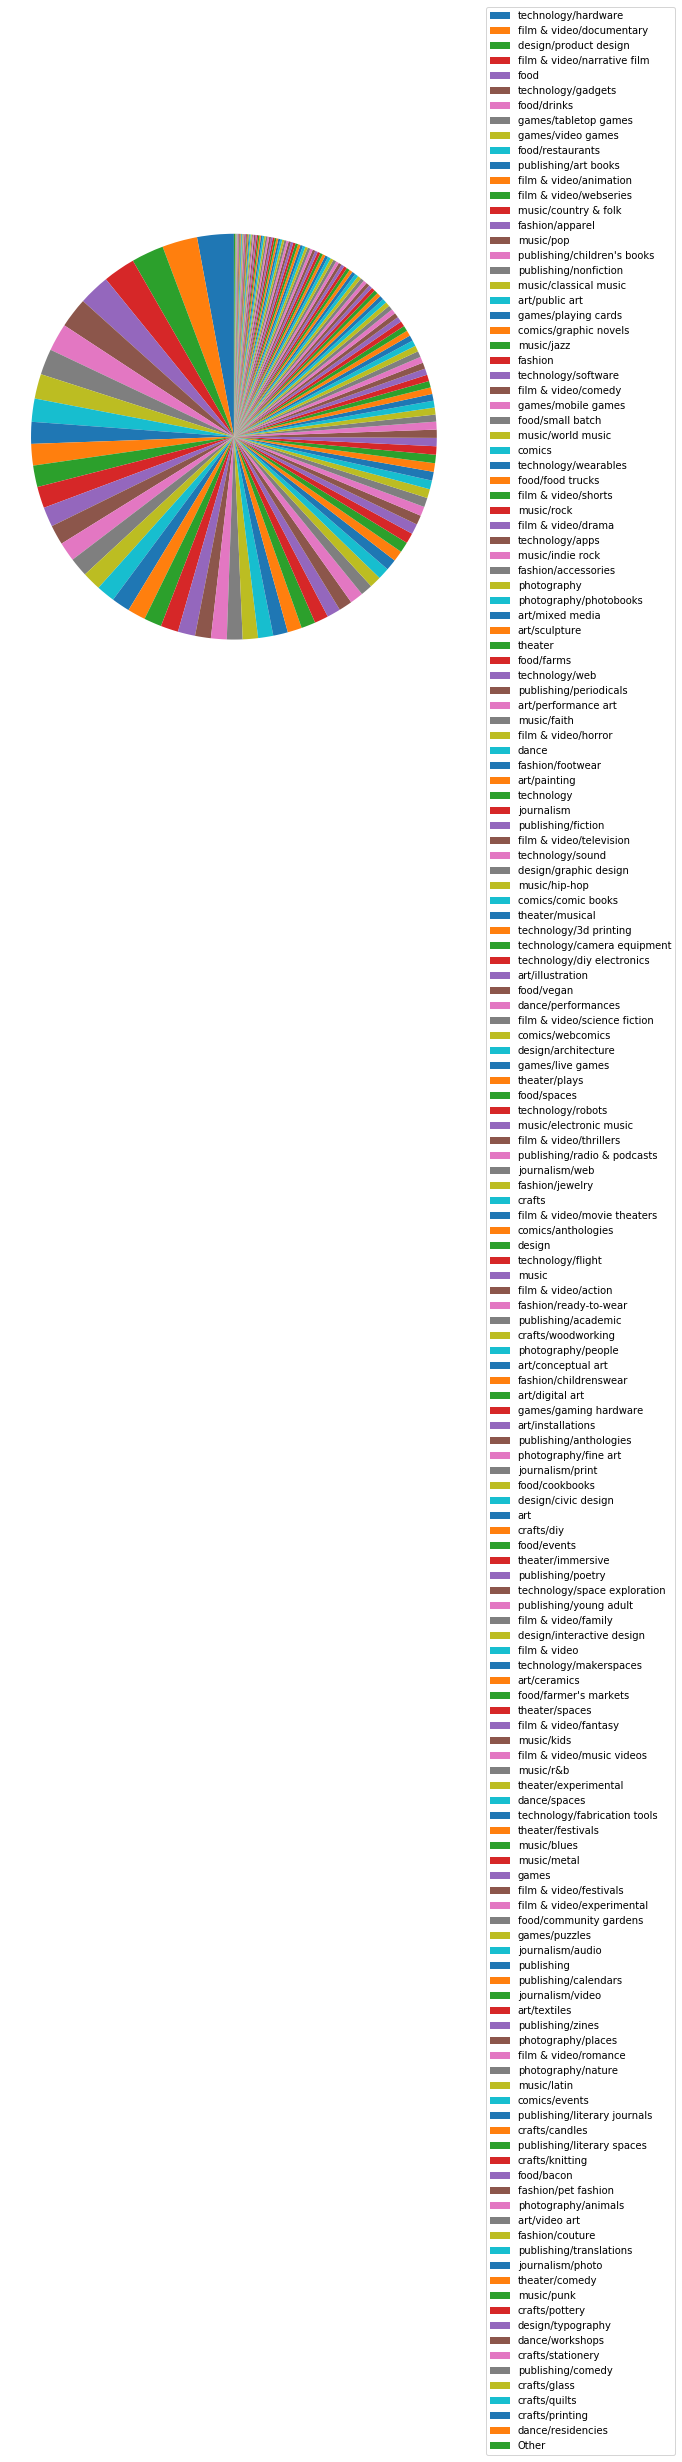

<Figure size 432x288 with 0 Axes>

In [202]:
labels = list(category_num.keys())
all_num = [ele[1] for ele in category_num.values()]

new_dict = {}
other = 0
for i in range(len(all_num)):
    if all_num[i] > 9:
        new_dict[labels[i]] = all_num[i]
    else:
        other += all_num[i]
new_dict['Other'] = other

fig = plt.figure(figsize=(8, 8))
patches, texts = plt.pie(new_dict.values(), startangle=90)
plt.legend(patches, new_dict.keys(), loc="upper right", bbox_to_anchor=(1.5, 1.5))
plt.axis('equal')
plt.tight_layout()
plt.show()

plt.savefig(path3 + 'Categories_number_of_projects.png')

In [203]:
print(len(new_dict))

163


In [204]:
### CALCULATION - PROPORTION PER CATEGORY

# all
category_frac = dict()
for k, v in category_freq.items():
    category_frac[k] = [v / len(df1)]

# success
for k, v in category_freq.items():
    if k in category_success_freq.keys():
        category_frac[k].append(category_success_freq[k] / len(df1_success))
    else: # no successes in these categories
        category_frac[k].append(0)
# fail        
for k, v in category_freq.items():
    if k in category_fail_freq.keys():
        category_frac[k].append(category_fail_freq[k] / len(df1_fail))
    else:
        category_frac[k].append(0)
        
#-------------------

# competition
for k, v in category_freq.items():
    if k in competition_category_freq.keys():
        category_frac[k].append(competition_category_freq[k] / len(df3))
    else:
        category_frac[k].append(0)
        
# competition success
for k, v in category_freq.items():
    if k in competition_category_success_freq.keys():
        category_frac[k].append(competition_category_success_freq[k] / len(df3_success))
    else:
        category_frac[k].append(0)
        
# competition fail
for k, v in category_freq.items():
    if k in competition_category_fail_freq.keys():
        category_frac[k].append(competition_category_fail_freq[k] / len(df3_fail))
    else:
        category_frac[k].append(0)
        
# ------------------

# non-competition
for k, v in category_freq.items():
    if k in non_competition_category_freq.keys():
        category_frac[k].append(non_competition_category_freq[k] / len(df3_1))
    else:
        category_frac[k].append(0)
        
# non-competition success
for k, v in category_freq.items():
    if k in non_competition_category_success_freq.keys():
        category_frac[k].append(non_competition_category_success_freq[k] / len(df3_1_success))
    else:
        category_frac[k].append(0)
        
# non-competition fail
for k, v in category_freq.items():
    if k in non_competition_category_fail_freq.keys():
        category_frac[k].append(non_competition_category_fail_freq[k] / len(df3_1_fail))
    else:
        category_frac[k].append(0)

# ------------------
        
# Write calculations to csv files

df8 = pd.DataFrame(category_frac.items(), columns = ['category_name', 'proportion'])
with open(path2 + "/Proportion_Category.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','All','Success','Fail','Competition', \
                     'Competition Success', 'Competition Fail', 'Non-Competition',\
                    'Non-Competition Success', 'Non-Competition Fail'])
    for i in range(len(df8['proportion'])):
        lst1 = list(df8['proportion'])[i]
        if lst1[3] not in ['1.0','1','0.0','0']:
            lst2 = list(category_freq.keys())
            lst1.insert(0, str(lst2[i]))
            writer.writerow(lst1)

In [269]:
### CALCULATION - PROBABILITY OF SUCCESS PER CATEGORY

# probability of success per category conditional on competition

# creating list of categories with overlapping projects
competition_category_success_rate = {}
for i in category_freq:
    if i in category_multi_projects:
        if i in competition_category_success_freq.keys():
            temp3.append(1)
            competition_category_success_rate[i] = competition_category_success_freq[i] / competition_category_freq[i]
        else:
            if i in competition_category_freq.keys():
                competition_category_success_rate[i] = 0
            else:
                competition_category_success_rate[i] = -1000000
    else:
        competition_category_success_rate[i] = -1000000
    
# probability of success for aggregate categories conditional on competition
competition_success_rate = len(df3_success) / len(df3)
print("Probability of success conditional on competition:")
print(competition_success_rate)
temp1 = list(competition_category_success_rate.values())
temp1 = [value for value in temp1 if value != -1000000]
print("Averaging across categories:")
print(sum(temp1) / len(temp1))
print("Median across categories:")
print(statistics.median(temp1))

# --------------

# probability of success per category conditional on no competition

for i in category_freq:
    if i in category_single_projects or i in category_multi_projects:
        if i in non_competition_category_success_freq.keys():
            non_competition_category_success_rate[i] = non_competition_category_success_freq[i] / non_competition_category_freq[i]
        else:
            if i in non_competition_category_freq.keys():
                non_competition_category_success_rate[i] = 0
            else:
                non_competition_category_success_rate[i] = -1000000
    else:
        non_competition_category_success_rate[i] = -1000000
    
non_competition_success_rate = len(df3_1_success) / len(df3_1)
print("Probability of success conditional on non-competition:")
print(non_competition_success_rate)
temp2 = list(non_competition_category_success_rate.values())
temp2 = [value for value in temp2 if value != -1000000]
print("Averaging across categories:")
print(sum(temp2) / len(temp2))
print("Median across categories:")
print(statistics.median(temp2))

# --------------

# Write calculations to csv files

subsets = [category_success_rate, competition_category_success_rate, non_competition_category_success_rate]

prob_success = {}
for k in category_success_rate.keys():
    prob_success[k] = list(str(prob_success[k]) for prob_success in subsets)

df9 = pd.DataFrame(prob_success.items(), columns = ['category_name', 'prob_of_success'])
count_compete = 0
count_non_compete = 0
with open(path2 + "/Prob_Of_Success_Category.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['Category','All','Competition','Non-Competition', 'Difference'])
    lst2 = list(category_freq.keys())
    for i in range(len(df9['prob_of_success'])):
        lst = list(df9['prob_of_success'])[i]
        lst1 = [ '%.4f' % float(j) for j in lst]
        #if lst1[1] not in ['1.0000','1','0.0000','0'] and lst1[2] not in ['1.0000','1','0.0000','0']: # > 0 competing/non-competing projects
        lst1.insert(0, str(lst2[i]))
        diff = round(float(lst1[2]) - float(lst1[3]),4)
        lst1.insert(len(lst1),str(diff))
        if diff > 0 and abs(diff) <= 1:
            count_compete += 1
        elif abs(diff) <= 1:
            count_non_compete += 1
        writer.writerow(lst1)

print("Prob of success competition > non-competition for the following percentage of categories: ")
print("{:.2%}".format(count_compete / (count_compete + count_non_compete)))

# Overall probability of success:
# 0.6925666925666926

# 21.71% same prob of success
# 52.71% non-comp better
# 25.58% comp better

Probability of success conditional on competition:
0.6593606092809068
Averaging across categories:
0.5621152388413511
Median across categories:
0.5
Probability of success conditional on non-competition:
0.6203703703703703
Averaging across categories:
0.676645534276975
Median across categories:
0.725
Prob of success competition > non-competition for the following percentage of categories: 
25.75%


In [224]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

Prob of success competitive vs. non-competitive confidence interval:
(0.6593606092809068, 0.6549898384176581, 0.6637313801441554)
(0.6203703703703703, 0.5939143281318232, 0.6468264126089175)


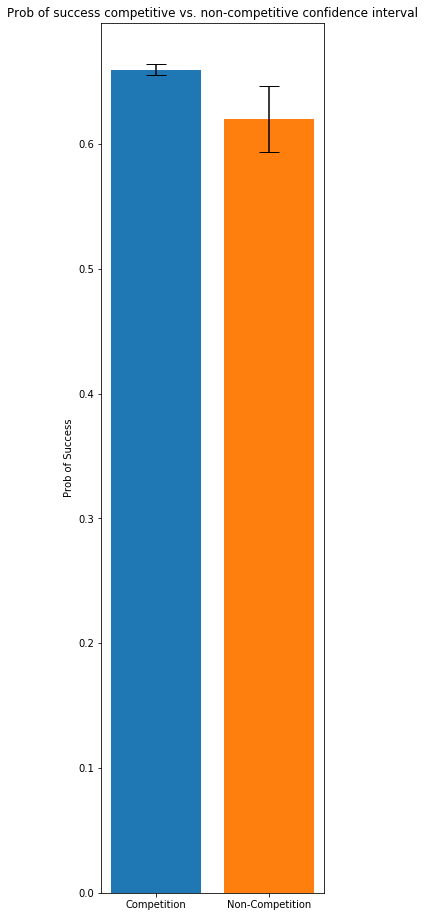

In [283]:
temp3 = []
for i in range(len(df3)):
    if i < len(df3_success):
        temp3.append(1)
    else:
        temp3.append(0)
x2, x1, x3 = mean_confidence_interval(temp3, 0.95)

print('Prob of success competitive vs. non-competitive confidence interval:')
print((x2, x1, x3))

temp4 = []
for i in range(len(df3_1)):
    if i < len(df3_1_success):
        temp4.append(1)
    else:
        temp4.append(0)

y2, y1, y3 = mean_confidence_interval(temp4, 0.95)

print((y2, y1, y3))

fig = plt.figure(figsize=(4, 16))
plt.bar('Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.title('Prob of success competitive vs. non-competitive confidence interval')
plt.ylabel('Prob of Success')
plt.show()

Prob of success among competitive vs. non-competitive categories confidence interval:
(0.5621152388413511, 0.5232722988313225, 0.6009581788513796)
(0.6766455342769749, 0.6330021826703187, 0.7202888858836312)


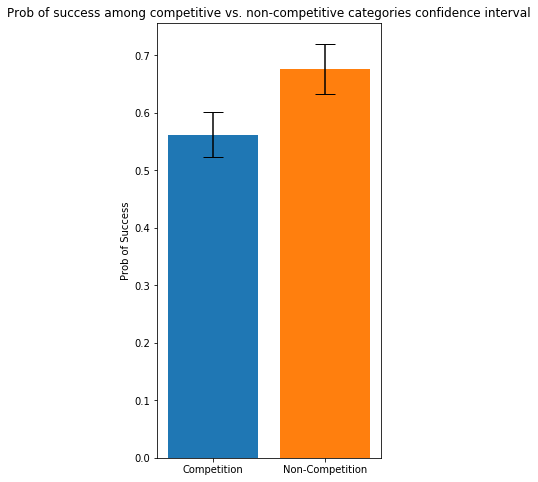

In [261]:
print('Prob of success among competitive vs. non-competitive categories confidence interval:')
x2, x1, x3 = mean_confidence_interval(temp1, 0.95)
y2, y1, y3 = mean_confidence_interval(temp2, 0.95)

print((x2, x1, x3))
print((y2, y1, y3))

fig = plt.figure(figsize=(4, 8))
plt.bar('Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.title('Prob of success among competitive vs. non-competitive categories confidence interval')
plt.ylabel('Prob of Success')
plt.show()

<class 'numpy.float64'>


All competitive vs. non-competitive projects goal confidence interval
(41579.752121413396, 36004.24299760026, 47155.26124522653)
(41038.10115740741, 22667.829357651506, 59408.37295716331)
(21416.63360821973, 20871.02879180415, 21962.23842463531)
(19713.90422885572, 17755.225526526985, 21672.582931184457)
(80608.60923566879, 64291.410758449725, 96925.80771288785)
(75884.95955284552, 27655.447285595656, 124114.4718200954)


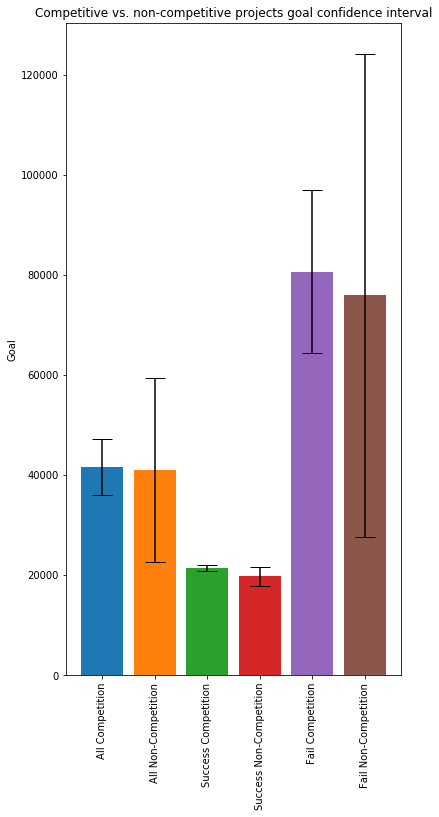

In [290]:
print('All competitive vs. non-competitive projects goal confidence interval')
x2, x1, x3 = mean_confidence_interval(list(df3['goal']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df3_1['goal']), 0.95)

x5, x4, x6 = mean_confidence_interval(list(df3_success['goal']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df3_1_success['goal']), 0.95)

x8, x7, x9 = mean_confidence_interval(list(df3_fail['goal']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df3_1_fail['goal']), 0.95)

print((x2, x1, x3))
print((y2, y1, y3))
print((x5, x4, x6))
print((y5, y4, y6))
print((x8, x7, x9))
print((y8, y7, y9))

fig = plt.figure(figsize=(6, 12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects goal confidence interval')
plt.ylabel('Goal')
plt.xticks(rotation = 'vertical')
plt.show()

All competitive vs. non-competitive projects pledged confidence interval
(32721.720350469357, 31273.777493405178, 34169.66320753354)
(23427.074575617284, 19484.15078940551, 27369.998361829057)
(47713.268524612184, 45538.92083852932, 49887.61621069505)
(35930.16611940298, 29746.859680411388, 42113.47255839458)
(3703.2433114519695, 3513.4000074848245, 3893.0866154191144)
(2995.1932723577233, 2173.840962934974, 3816.5455817804727)


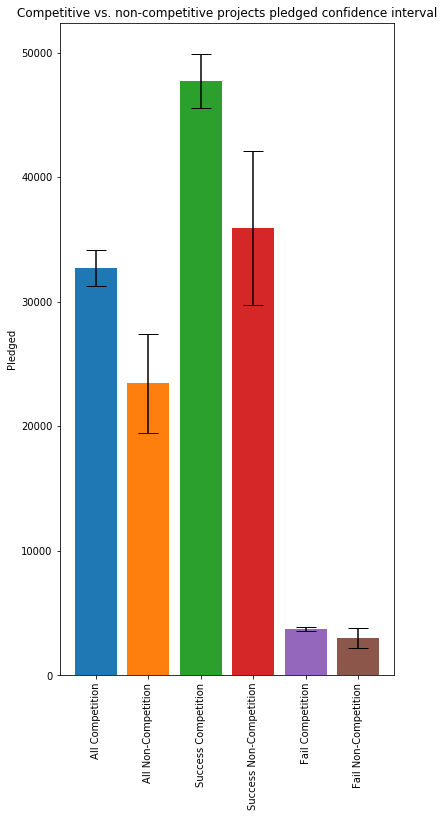

In [289]:
print('All competitive vs. non-competitive projects pledged confidence interval')
x2, x1, x3 = mean_confidence_interval(list(df3['usd_pledged']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df3_1['usd_pledged']), 0.95)

x5, x4, x6 = mean_confidence_interval(list(df3_success['usd_pledged']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df3_1_success['usd_pledged']), 0.95)

x8, x7, x9 = mean_confidence_interval(list(df3_fail['usd_pledged']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df3_1_fail['usd_pledged']), 0.95)

print((x2, x1, x3))
print((y2, y1, y3))
print((x5, x4, x6))
print((y5, y4, y6))
print((x8, x7, x9))
print((y8, y7, y9))

fig = plt.figure(figsize=(6, 12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects pledged confidence interval')
plt.ylabel('Pledged')
plt.xticks(rotation = 'vertical')
plt.show()

All competitive vs. non-competitive projects backers confidence interval
(356.275726177825, 340.3302314280677, 372.2212209275823)
(265.18364197530866, 226.0032512110457, 304.36403273957166)
(521.3402726479081, 497.38118512950786, 545.2993601663085)
(406.83706467661693, 345.81373899924773, 467.86039035398613)
(36.7675809177174, 35.40253704338157, 38.132624792053235)
(33.701219512195124, 26.81011969107786, 40.59231933331239)


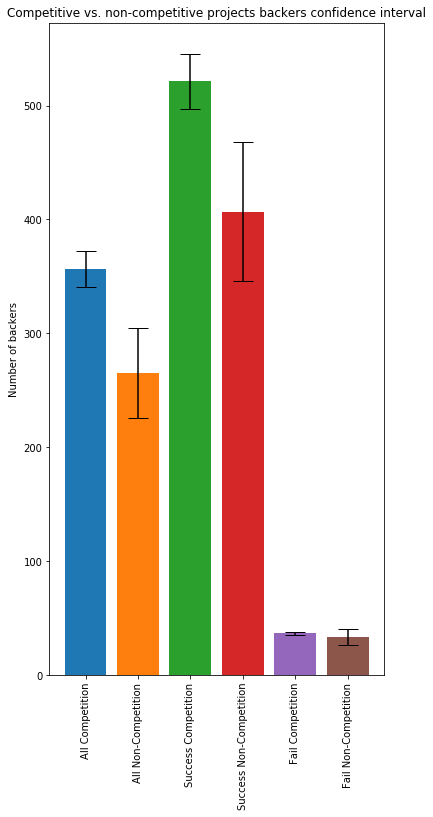

In [288]:
print('All competitive vs. non-competitive projects backers confidence interval')
x2, x1, x3 = mean_confidence_interval(list(df3['backers_count']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df3_1['backers_count']), 0.95)

x5, x4, x6 = mean_confidence_interval(list(df3_success['backers_count']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df3_1_success['backers_count']), 0.95)

x8, x7, x9 = mean_confidence_interval(list(df3_fail['backers_count']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df3_1_fail['backers_count']), 0.95)

print((x2, x1, x3))
print((y2, y1, y3))
print((x5, x4, x6))
print((y5, y4, y6))
print((x8, x7, x9))
print((y8, y7, y9))

fig = plt.figure(figsize=(6, 12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects backers confidence interval')
plt.ylabel('Number of backers')
plt.xticks(rotation = 'vertical')
plt.show()

/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

All competitive vs. non-competitive projects duration confidence interval
(3.2495778186822615, 3.2081511162323637, 3.2910045211321592)
(1.6860606194488312, 1.619098905461201, 1.7530223334364614)
(3.178941085994851, 3.1303331601160878, 3.227549011873614)
(1.7900869669712498, 1.706297384180591, 1.8738765497619085)
(3.3863062193644695, 3.309289073546822, 3.463323365182117)
(1.5160663442292692, 1.4061486087530943, 1.6259840797054441)


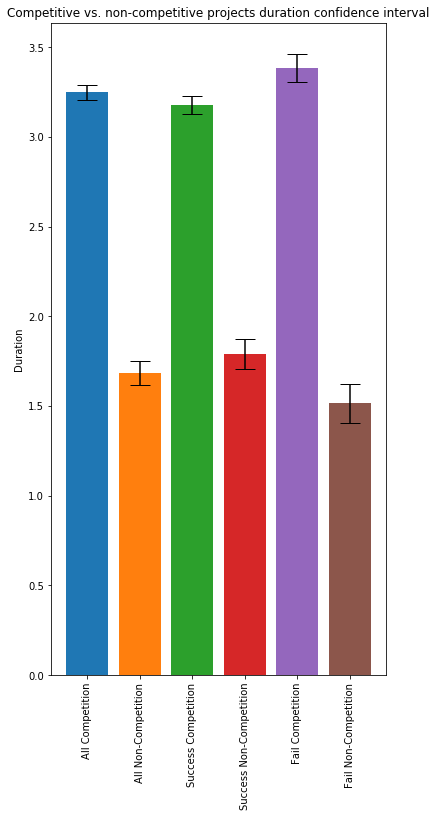

In [292]:
df3['duration'] = (df3['deadline'] - df3['created_at']) / np.timedelta64(1,'M')
df3_1['duration'] = (df3_1['deadline'] - df3_1['created_at']) / np.timedelta64(1,'M')

df3_success['duration'] = (df3_success['deadline'] - df3_success['created_at']) / np.timedelta64(1,'M')
df3_1_success['duration'] = (df3_1_success['deadline'] - df3_1_success['created_at']) / np.timedelta64(1,'M')

df3_fail['duration'] = (df3_fail['deadline'] - df3_fail['created_at']) / np.timedelta64(1,'M')
df3_1_fail['duration'] = (df3_1_fail['deadline'] - df3_1_fail['created_at']) / np.timedelta64(1,'M')

print('All competitive vs. non-competitive projects duration confidence interval')
x2, x1, x3 = mean_confidence_interval(list(df3['duration']), 0.95)
y2, y1, y3 = mean_confidence_interval(list(df3_1['duration']), 0.95)

x5, x4, x6 = mean_confidence_interval(list(df3_success['duration']), 0.95)
y5, y4, y6 = mean_confidence_interval(list(df3_1_success['duration']), 0.95)

x8, x7, x9 = mean_confidence_interval(list(df3_fail['duration']), 0.95)
y8, y7, y9 = mean_confidence_interval(list(df3_1_fail['duration']), 0.95)

print((x2, x1, x3))
print((y2, y1, y3))
print((x5, x4, x6))
print((y5, y4, y6))
print((x8, x7, x9))
print((y8, y7, y9))

fig = plt.figure(figsize=(6, 12))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects duration confidence interval')
plt.ylabel('Duration')
plt.xticks(rotation = 'vertical')
plt.show()

All competitive vs. non-competitive projects P/G confidence interval
(1.3071631295862718, 1.2790607679373835, 1.33526549123516)
(1.1096323522237739, 0.9864197176996741, 1.2328449867478737)
(1.9147731619182127, 1.8738473439161956, 1.9556989799202298)
(1.706500823753075, 1.5196518250963331, 1.8933498224098169)
(0.13103925184612766, 0.12840396221192077, 0.13367454148033456)
(0.134261923139306, 0.11831119912015362, 0.15021264715845836)


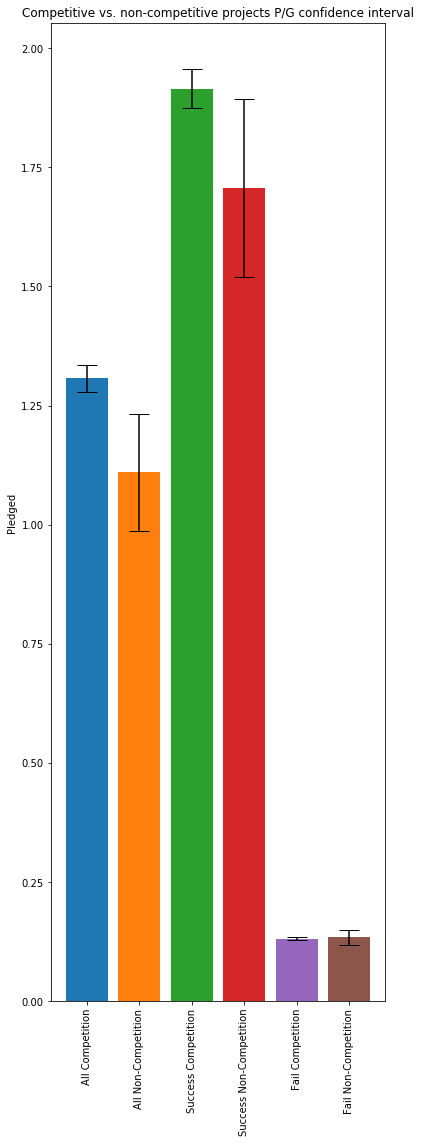

In [296]:
print('All competitive vs. non-competitive projects P/G confidence interval')
new_lst1 = [x/y for x, y in zip(list(df3['usd_pledged']), list(df3['goal']))]
new_lst2 = [x/y for x, y in zip(list(df3_1['usd_pledged']), list(df3_1['goal']))]
x2, x1, x3 = mean_confidence_interval(new_lst1, 0.95)
y2, y1, y3 = mean_confidence_interval(new_lst2, 0.95)

new_lst3 = [x/y for x, y in zip(list(df3_success['usd_pledged']), list(df3_success['goal']))]
new_lst4 = [x/y for x, y in zip(list(df3_1_success['usd_pledged']), list(df3_1_success['goal']))]
x5, x4, x6 = mean_confidence_interval(new_lst3, 0.95)
y5, y4, y6 = mean_confidence_interval(new_lst4, 0.95)

new_lst5 = [x/y for x, y in zip(list(df3_fail['usd_pledged']), list(df3_fail['goal']))]
new_lst6 = [x/y for x, y in zip(list(df3_1_fail['usd_pledged']), list(df3_1_fail['goal']))]
x8, x7, x9 = mean_confidence_interval(new_lst5, 0.95)
y8, y7, y9 = mean_confidence_interval(new_lst6, 0.95)

print((x2, x1, x3))
print((y2, y1, y3))
print((x5, x4, x6))
print((y5, y4, y6))
print((x8, x7, x9))
print((y8, y7, y9))

fig = plt.figure(figsize=(6, 18))
plt.bar('All Competition', x2, yerr = x3-x2, capsize = 10)
plt.bar('All Non-Competition', y2, yerr = y3-y2, capsize = 10)
plt.bar('Success Competition', x5, yerr = x6-x5, capsize = 10)
plt.bar('Success Non-Competition', y5, yerr = y6-y5, capsize = 10)
plt.bar('Fail Competition', x8, yerr = x9-x8, capsize = 10)
plt.bar('Fail Non-Competition', y8, yerr = y9-y8, capsize = 10)
plt.title('Competitive vs. non-competitive projects P/G confidence interval')
plt.ylabel('Pledged')
plt.xticks(rotation = 'vertical')
plt.show()